# Dating Textual Documents

Given a short text in English, we wish to perform a classification in predicting which among 10 authors who wrote it. We think that writing style tend to vary extensively with author, and we we hope to build a model that can recognize this difference in a consistent way. 

# Data sources
- http://www.gutenberg.org/

# Data Retrieval

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt

# Cleaning the data 

<b> Scraping gutenberg.org and goodreads.com to retrieve the relevant texts and their publishing year </b>

From gutenberg.org we want to retrieve as many books as possible in .txt format. The website has about 60 000 books in its catalog, not all of which are of interst to us, e.g. those that are in a different language than English. We think that limiting  our dataset to fiction books with English as its original language makes our dataset more uniform and will prove beneficial for analysis later on. Fortunately, goodreads.com has a catalog which lists 500+ books that more or less satisfy these criteria. We used the data from goodreads.com to obtain the dataset of relevant books (and their publishing year), which we then used to scrape gutenberg.org to retrieve the actual texts. 

<b> Pre-processing a text </b>

Given a written work that can be accessed from gutenberg.org, we wish to (eventually) obtain a dataset which captures word and punctuation frequency, distribution of sentence lengths, and possibly other features. NLTK makes the process of retrieving word frequencies relatively simple. Using the "FreqDist" class, we can produce a list with all words and the number of times they appear in the form of a list of tuples: [(<word>, <word count>), ...]. 

# Data visualization

Load the goodreads_catalog.csv and gutenberg_catalog.csv. 

In [26]:
gr_df = pd.read_csv('goodreads_catalog.csv')
gr_df.columns = ['title','author','year']
gr_df.head(5)

,title,author,year
0,The Mysterious Affair at Styles,Agatha Christie,1920
1,Pride and Prejudice,Jane Austen,1813
2,The Picture of Dorian Gray,Oscar Wilde,1890
3,Jane Eyre,Charlotte Brontë,1847
4,The Time Machine,H.G. Wells,1895


In [27]:
gb_df = pd.read_csv('gutenberg_catalog.csv')
gb_df.columns = ['title','author','book_id']
gb_df.head(5)

,title,author,book_id
0,Healthful Sports for Young Ladies,St. Sernin,57057
1,Winning his Wings,Percy F. Westerman,57056
2,"Baily's Magazine of Sports and Pastimes, Volum...",Various,57055
3,Flat Machine Knitting and Fabrics,H. D. Buck,57054
4,The Fall of the Great Republic (1886-88),Henry Standish Coverdale,57049


Merge the dataframes from goodreads_catalog.csv and gutenberg_catalog.csv so matching titles will contains information about author, publishing date, and book id information. 

In [28]:
gr_df["title"] = gr_df["title"].str.lower()
gr_df["title"] = gr_df["title"].str.replace(r'[,.:;-?]', '')
gb_df["title"] = gb_df["title"].str.lower()
gb_df["title"] = gb_df["title"].str.replace(r'[,.:-;?]', '')
combined = pd.merge(gr_df, gb_df, on='title')

In [29]:
combined.head(5)

,title,author_x,year,author_y,book_id
0,the mysterious affair at styles,Agatha Christie,1920,Agatha Christie,863
1,pride and prejudice,Jane Austen,1813,Jane Austen,42671
2,pride and prejudice,Jane Austen,1813,Jane Austen,1342
3,the picture of dorian gray,Oscar Wilde,1890,Oscar Wilde,26740
4,the picture of dorian gray,Oscar Wilde,1890,Oscar Wilde,4078


We deleted all duplicates titles so we consider the first instant as the correct book. 

In [34]:
combined = combined.sort_values(by='book_id')
combined = combined.drop_duplicates(subset='title')
combined = combined[combined['year'] > 0]

In [35]:
len(combined)

699

In [21]:
counter=0
for index, row in combined.iterrows():
    book_id = int(row['book_id'])

    try:
        urlretrieve( "http://www.gutenberg.org/files/{}/{}.txt".format(book_id, book_id), "books/{}_{}.txt".format( row['title'].replace(' ', '_'), book_id) )
        counter+=1
        print(row['title'], row['author_x'], row['year'], row['book_id'])
        
    except urllib.request.HTTPError:
        try:
            urlretrieve( "http://www.gutenberg.org/files/{}/{}-0.txt".format(book_id, book_id), "books/{}_{}.txt".format( row['title'].replace(' ', '_'), book_id) )
            counter+=1
            print("URL_TYPE_2", row['title'], row['author_x'], row['year'], row['book_id'])
        
        except urllib.request.HTTPError:
            try:
                urlretrieve( "http://www.gutenberg.org/cache/epub/{}/pg{}.txt".format(book_id, book_id), "books/{}_{}.txt".format( row['title'].replace(' ', '_'), book_id) )
                counter+=1
                print("URL_TYPE_3", row['title'], row['author_x'], row['year'], row['book_id'])
            
            except urllib.request.HTTPError: 
                print("**********NOT FOUND", row['title'], row['author_x'], row['year'], row['book_id'])

print(counter)

alice's adventures in wonderland Lewis Carroll 1865 11
the hunting of the snark Lewis Carroll 1876 13
peter pan J.M. Barrie 1904 16
paradise lost John Milton 1667 20
aesop's fables Aesop 560 21
far from the madding crowd Thomas Hardy 1874 27
the scarlet letter Nathaniel Hawthorne 1850 33
the time machine H.G. Wells 1895 35
the war of the worlds H.G. Wells 1898 36
the legend of sleepy hollow Washington Irving 1820 41
the strange case of dr jekyll and mr hyde Robert Louis Stevenson 1886 42
anne of green gables L.M. Montgomery 1908 45
anne of avonlea L.M. Montgomery 1909 47
anne of the island L.M. Montgomery 1915 51
the wonderful wizard of oz L. Frank Baum 1900 55
the scarlet pimpernel Emmuska Orczy 1905 60
the communist manifesto Karl Marx 1848 61
a princess of mars Edgar Rice Burroughs 1912 62
the gods of mars Edgar Rice Burroughs 1913 64
URL_TYPE_2 what is man Mark Twain 1905 70
the red badge of courage Stephen Crane 1895 73
the house of the seven gables Nathaniel Hawthorne 1851 77
tar

the first men in the moon H.G. Wells 1901 1013
URL_TYPE_2 the soul of man under socialism Oscar Wilde 1891 1017
URL_TYPE_2 walking Henry David Thoreau 1862 1022
bleak house Charles Dickens 1853 1023
the lone star ranger Zane Grey 1914 1027
the professor Charlotte Brontë 1857 1028
shakespeare's sonnets William Shakespeare 1609 1041
sartor resartus Thomas Carlyle 1834 1051
martin eden Jack London 1909 1056
the raven Edgar Allan Poe 1844 1063
URL_TYPE_2 the sea wolf Jack London 1904 1074
the life and opinions of tristram shandy gentleman Laurence Sterne 1759 1079
a modest proposal Jonathan Swift 1729 1080
dead souls Nikolai Gogol 1842 1081
URL_TYPE_2 a horse's tale Mark Twain 1907 1086
romeo and juliet William Shakespeare 1597 1112
a midsummer night's dream William Shakespeare 1595 1113
much ado about nothing William Shakespeare 1598 1118
macbeth William Shakespeare 1606 1129
the winter's tale William Shakespeare 1611 1134
the tempest William Shakespeare 1623 1135
the nibelungenlied Unkno

URL_TYPE_2 a portrait of the artist as a young man James Joyce 1916 4217
URL_TYPE_2 women in love D.H. Lawrence 1920 4240
wives and daughters Elizabeth Gaskell 1866 4274
north and south Elizabeth Gaskell 1855 4276
URL_TYPE_2 ulysses James Joyce 1922 4300
URL_TYPE_3 the odd women George Gissing 1893 4313
american fairy tales L. Frank Baum 1901 4357
beyond good and evil Friedrich Nietzsche 1886 4363
aaron's rod D.H. Lawrence 1922 4520
basil Wilkie Collins 1852 4605
a sweet girl graduate L.T. Meade 1891 4989
the spoilers Rex Beach 1905 5076
URL_TYPE_2 the man of feeling Henry MacKenzie 1771 5083
childe harold's pilgrimage George Gordon Byron 1812 5131
what katy did at school Susan Coolidge 1873 5141
URL_TYPE_2 the mabinogion Unknown 1410 5160
the countess cathleen W.B. Yeats 1892 5167
the invisible man H.G. Wells 1897 5230
the way we live now Anthony Trollope 1875 5231
the old wives' tale Arnold Bennett 1908 5247
the land of the blue flower Frances Hodgson Burnett 1908 5302
the little hun

candide Voltaire 1759 19942
the napoleon of notting hill G.K. Chesterton 1904 20058
sarah's school friend May Baldwin 1910 20068
edward ii Christopher Marlowe 1598 20288
roumanian fairy tales Mite Kremnitz 1885 20552
the skylark of space E.E. "Doc" Smith 1928 20869
just patty Jean Webster 1911 21048
a pirate of the caribbees Harry Collingwood 2007 21073
the independence of claire Mrs. George de Horne Vaizey 1915 21098
a college girl Mrs. George de Horne Vaizey 1913 21110
the four pools mystery Jean Webster 1908 21264
the children of the new forest Frederick Marryat 1847 21558
when patty went to college Jean Webster 1903 21639
the confidence-man Herman Melville 1857 21816
planet of the damned Harry Harrison 1962 21873
URL_TYPE_2 embarrassments Henry James 1896 21932
security Poul Anderson 1953 22239
the book of the damned Charles Fort 1919 22472
grimm tales made gay Guy Wetmore Carryl 1902 23024
quite so Thomas Bailey Aldrich 2011 23359
why they married James Montgomery Flagg 1906 23611

URL_TYPE_2 twenty-five ghost stories W. Bob Holland 1950 53419
URL_TYPE_2 the wisdom of fools Margaret Deland 2005 53579
the senator's bride Mrs. Alex. McVeigh Miller 1897 54134
what jesus taught Osborne John Peter Widtsoe 2016 54292
URL_TYPE_2 oblomov Ivan Goncharov 1859 54700
URL_TYPE_3 folk tales of breffny Bampton Hunt 2015 54724
URL_TYPE_3 the senator's favorite Mrs. Alex. McVeigh Miller 1897 55237
URL_TYPE_2 twenty drawings Kahlil Gibran 1974 55500
URL_TYPE_2 fairy tales from gold lands May Wentworth Newman 2013 56155
URL_TYPE_2 patty's pleasure trip Carolyn Wells 2008 56552
URL_TYPE_2 patty in the city Carolyn Wells 1905 56583
URL_TYPE_2 what a girl can make and do Lina Beard 1902 56588
URL_TYPE_2 idle hours in a library William Henry Hudson 1897 56659
697


# Visualization # 1
Show the frequency of the number of books we have for each year. We willl consider the years after 1800's for better visualization. As we can see, we don't have an abundance of books for each year as of now. However, with an improved parser we hope to obtain at least 15 books for each 5 year period. Moreover, splitting the texts into chunks will yield a considerably larger dataset for each year.

In [36]:
frequency = combined['year'].value_counts()

In [37]:
frequency = frequency.sort_index()

In [38]:
frequency = frequency[frequency.index > 1700]

Text(0,0.5,'Number of Books')

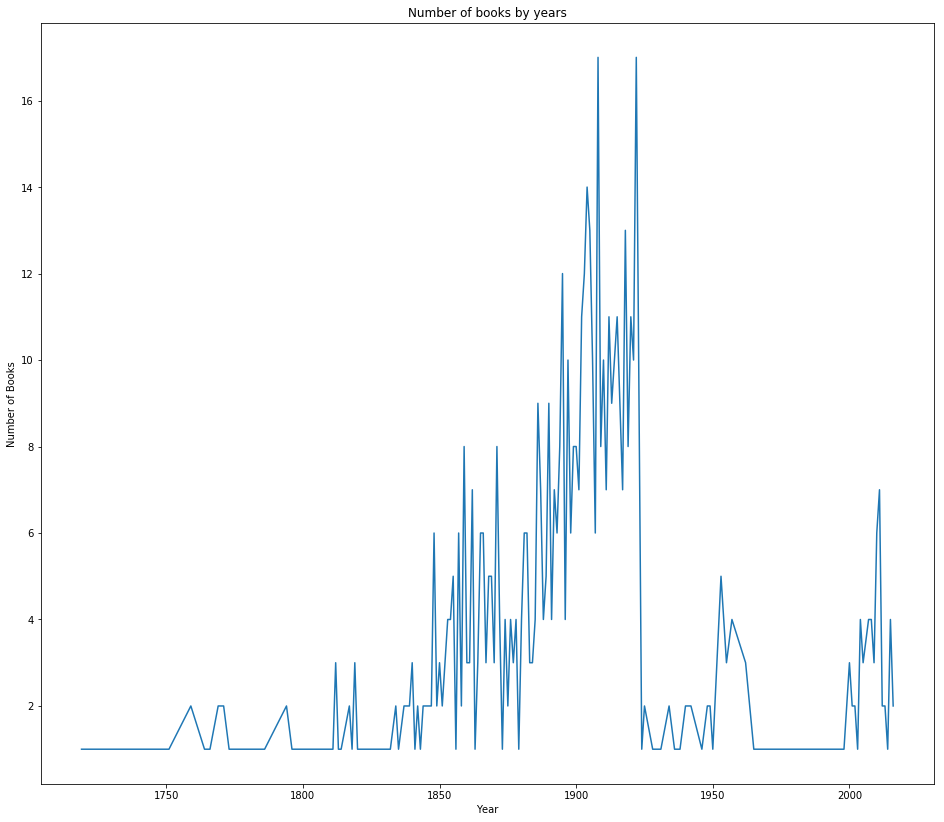

In [39]:
ax = frequency.plot(kind='line', figsize=(16,14), title='Number of books by years')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Books")

# Visualization # 2
Show the frequency of the 50 most common used words/punctuation in "Pride and Prejudice"

In [32]:
file = open("books/book1342.txt",'r')
text=file.read()

tokenizer = TweetTokenizer()
tokens = tokenizer.tokenize(text)
fdist = nltk.FreqDist(tokens)
d = {'word': list(dict(fdist).keys()), 'frequency':list(dict(fdist).values())}

df = pd.DataFrame(d, columns=['word', 'frequency'])
df = df.sort_values(by='frequency')
total_number_of_words = len(df)
most_common_words_df = df.tail(50)

Text(0,0.5,'Number of Recurrence')

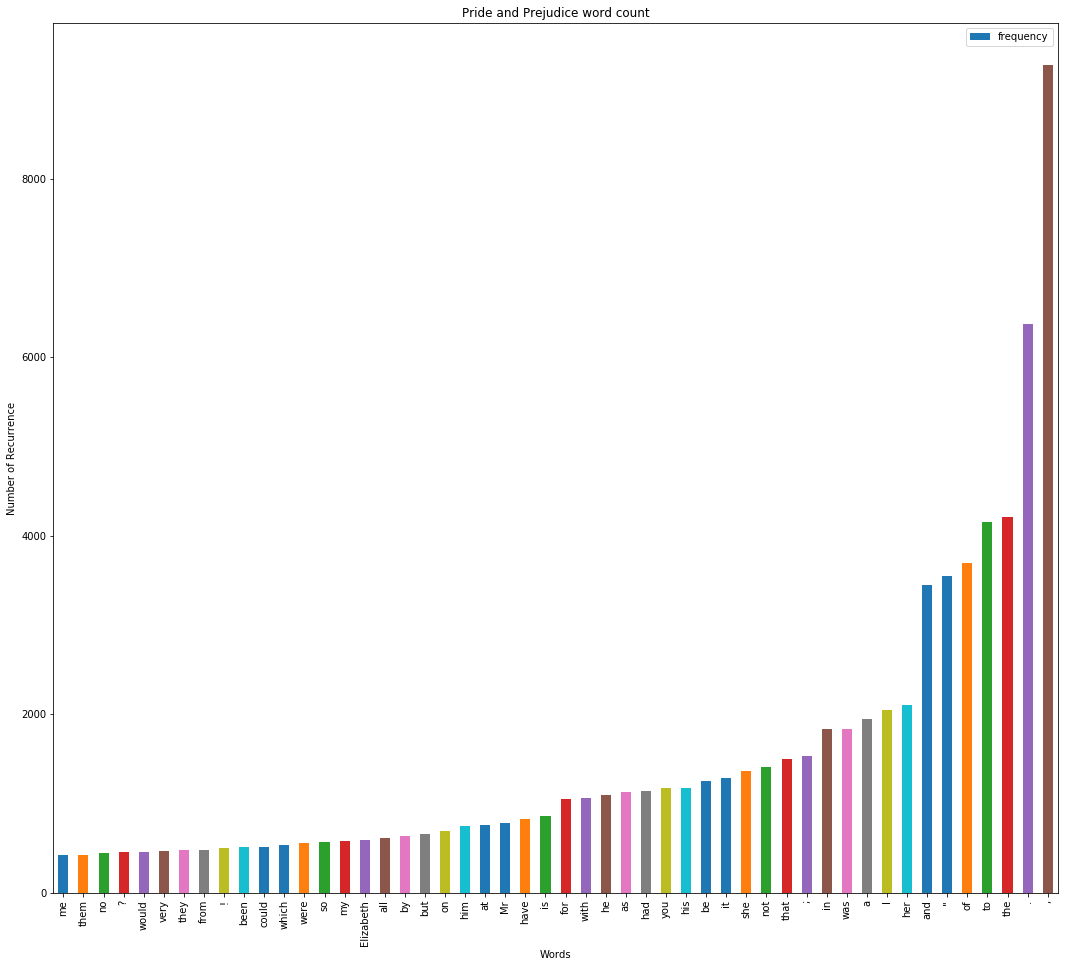

In [33]:
ax = most_common_words_df.plot.bar(x="word", y="frequency",figsize=(18,16), title='Pride and Prejudice word count')
ax.set_xlabel("Words")
ax.set_ylabel("Number of Recurrence")

# Visualization # 3
Show the frequency of the word "the" with the years of 1800 to 1900. Since "the" is such a generic word, it is perhaps not too surprising that no relationship or pattern is observed. Moreover, with more books to relationships will hopefully be found.

In [ ]:
the_percentages = []
years = []
tknzr = TweetTokenizer()

for index, row in combined.iterrows():
        book_id = int(row['book_id'])
        year = int(row['date'])
        if year > 1800 and year < 1900:
            print(book_id, year)
            try:
                file = open("Test_books/book{}.txt".format(book_id),'r')
                text = file.read()
                fdist = nltk.FreqDist(tknzr.tokenize(text))
                the_percentages.append(fdist["the"]/len(tknzr.tokenize(s)))
                years.append(year)


            except (UnicodeDecodeError, FileNotFoundError)  as e:
                pass
    
    

the_freq_df = pd.DataFrame({"years" : years, "the" : the_percentages})

In [ ]:
the_freq_df.head(20)

In [ ]:
ax = the_freq_df.plot.scatter(x="years", y="the",figsize=(18,16), title='Years (1800-1900) percent of "the"')
ax.set_ylabel("% of \"the\" in book")
ax.set_xlabel("Year")

In [ ]:
the_freq_df["years"].corr(the_freq_df["the"])

As seen in the correlation, there is almost no correlation between year and % of "the".